In [171]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas

In [81]:
spark = SparkSession \
    .builder \
    .appName("BIG DATA PROJECT") \
    .getOrCreate()

In [82]:
df = spark.read.option("header",True) \
    .json('News_Category_Dataset_v2.json')

In [83]:
df.columns

['authors', 'category', 'date', 'headline', 'link', 'short_description']

In [84]:
df.dtypes

[('authors', 'string'),
 ('category', 'string'),
 ('date', 'string'),
 ('headline', 'string'),
 ('link', 'string'),
 ('short_description', 'string')]

In [85]:
newsSchema = StructType([
  StructField("authors", StringType(), False),
  StructField("category", StringType(), False),
  StructField("date", StringType(), False),
  StructField("headline", StringType(), False),
  StructField("link", StringType(), False),
  StructField("short_description", StringType(), False),
])
newsData = spark.read.json('News_Category_Dataset_v2.json', 
                         schema=newsSchema)

In [86]:
newsData.show(5)

+---------------+-------------+----------+--------------------+--------------------+--------------------+
|        authors|     category|      date|            headline|                link|   short_description|
+---------------+-------------+----------+--------------------+--------------------+--------------------+
|Melissa Jeltsen|        CRIME|2018-05-26|There Were 2 Mass...|https://www.huffi...|She left her husb...|
|  Andy McDonald|ENTERTAINMENT|2018-05-26|Will Smith Joins ...|https://www.huffi...|Of course it has ...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Hugh Grant Marrie...|https://www.huffi...|The actor and his...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Jim Carrey Blasts...|https://www.huffi...|The actor gives D...|
|     Ron Dicker|ENTERTAINMENT|2018-05-26|Julianna Margulie...|https://www.huffi...|The "Dietland" ac...|
+---------------+-------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [115]:
def count_missings(newsData,sort=True):
    df = newsData.select([count(when(isnan(c) | isnull(c), c)).alias(c) for (c,c_type) in newsData.dtypes if c_type not in ('timestamp', 'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [116]:
count_missings(newsData)

,count
authors,0
category,0
date,0
headline,0
link,0
short_description,0


In [87]:
category_count = newsData.groupBy("category").agg({"category": "count"}).collect()
categoryDf = spark.createDataFrame(category_count, ["category", "counts"])

In [88]:
categoryDf.show()

+--------------+------+
|      category|counts|
+--------------+------+
|        SPORTS|  4884|
|         MEDIA|  2815|
|  BLACK VOICES|  4528|
|      POLITICS| 32739|
|          ARTS|  1509|
| THE WORLDPOST|  3664|
|  QUEER VOICES|  6314|
|CULTURE & ARTS|  1030|
|     PARENTING|  8677|
|         GREEN|  2622|
| ENTERTAINMENT| 16058|
|   ENVIRONMENT|  1323|
|          TECH|  2082|
|      BUSINESS|  5937|
| LATINO VOICES|  1129|
|        COMEDY|  5175|
|STYLE & BEAUTY|  9649|
|         MONEY|  1707|
|        IMPACT|  3459|
|      RELIGION|  2556|
+--------------+------+
only showing top 20 rows



In [89]:
max_category = categoryDf.agg({"counts": "max"}).collect()[0]
print(max_category)

Row(max(counts)=32739)


In [90]:
max_category_name = categoryDf.where(categoryDf["counts"] == max_category[0])
max_category_name.show()

+--------+------+
|category|counts|
+--------+------+
|POLITICS| 32739|
+--------+------+



In [91]:
min_category = categoryDf.agg({"counts": "min"}).collect()[0]
print(min_category)

Row(min(counts)=1004)


In [92]:
min_category_name = categoryDf.where(categoryDf["counts"] == min_category[0])
min_category_name.show()

+---------+------+
| category|counts|
+---------+------+
|EDUCATION|  1004|
+---------+------+



<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

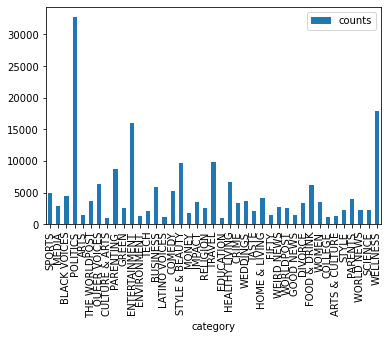

<Figure size 432x288 with 0 Axes>

In [147]:
plt.figure(figsize=(10,5))
df = categoryDf.toPandas()
df.plot(kind="bar",x="category",y="counts")
display(plt.figure())


In [97]:
author_count = newsData.groupBy("authors").agg({"authors": "count"}).collect()
authorDf = spark.createDataFrame(author_count, ["authors", "counts"])

In [98]:
authorDf.show()

+--------------------+------+
|             authors|counts|
+--------------------+------+
|Zach Carter, Arth...|     2|
|    Maxwell Strachan|   462|
|Steve Holland, Re...|    40|
|Lisa Rapaport, Re...|    77|
|Andy Campbell, Ni...|     1|
|Antonia Blumberg ...|     1|
|Oliver Balch, On ...|     2|
|Carol J. Clouse, ...|     2|
|Steven Rosenbaum ...|    16|
|Chris Jordan, Con...|     1|
|Lisa Derrick, Con...|     1|
|Dejan Jotanovic, ...|     2|
|Howard Schneider,...|     1|
|Ross Kerber, Reuters|     2|
|Dan Whitcomb, Reu...|     8|
|Steven Lim, Contr...|     1|
|Nick Visser and J...|     1|
|David Lohr, Kate ...|     1|
|Yulia Denisyuk, C...|     1|
|Jennie Burnet, Ph...|     1|
+--------------------+------+
only showing top 20 rows



In [125]:
max_news = authorDf.agg({"counts": "max"}).dropna().collect()[0]
print(max_news)

Row(max(counts)=36620)


In [139]:
max_news_author = authorDf.where(authorDf["counts"] == max_news[0])
max_news_author.show(2)

+-------+------+
|authors|counts|
+-------+------+
|       | 36620|
+-------+------+



In [132]:
min_news = authorDf.agg({"counts": "min"}).dropna().collect()[0]
print(min_news)

Row(min(counts)=1)


In [137]:
min_news_author = authorDf.where(authorDf["counts"] == min_news[0])
min_news_author.show(1)

+--------------------+------+
|             authors|counts|
+--------------------+------+
|Andy Campbell, Ni...|     1|
+--------------------+------+
only showing top 1 row



In [245]:
newsperday = newsData.groupby(newsData["date"]).agg(count('date'))
newsperday = newsperday.withColumn("UDate", unix_timestamp(newsperday['date'], "yyyy-MM-dd"))

newsperday.show()

+----------+-----------+----------+
|      date|count(date)|     UDate|
+----------+-----------+----------+
|2017-12-05|         96|1512412200|
|2017-05-14|         70|1494700200|
|2016-08-17|         95|1471372200|
|2015-05-01|         87|1430418600|
|2014-12-13|         90|1418409000|
|2014-05-27|         86|1401129000|
|2014-02-22|         80|1393007400|
|2014-02-16|         72|1392489000|
|2013-03-14|        100|1363199400|
|2017-12-22|         76|1513881000|
|2017-10-20|         95|1508437800|
|2017-05-11|         98|1494441000|
|2017-02-24|         99|1487874600|
|2016-09-11|         72|1473532200|
|2016-08-20|         80|1471631400|
|2016-08-08|         95|1470594600|
|2016-04-22|         93|1461263400|
|2015-02-27|         85|1424975400|
|2015-02-09|         81|1423420200|
|2014-12-11|         82|1418236200|
+----------+-----------+----------+
only showing top 20 rows



In [258]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime
import matplotlib.pyplot as plt


newsperday_pandas = newsperday.orderBy(asc("Udate"))

newsperday_pandas.show()


+----------+-----------+----------+
|      date|count(date)|     UDate|
+----------+-----------+----------+
|2012-01-28|         66|1327689000|
|2012-01-29|         65|1327775400|
|2012-01-30|        100|1327861800|
|2012-01-31|        100|1327948200|
|2012-02-01|        100|1328034600|
|2012-02-02|        100|1328121000|
|2012-02-03|        100|1328207400|
|2012-02-04|         70|1328293800|
|2012-02-05|         68|1328380200|
|2012-02-06|        100|1328466600|
|2012-02-07|        100|1328553000|
|2012-02-08|        100|1328639400|
|2012-02-09|        100|1328725800|
|2012-02-10|        100|1328812200|
|2012-02-11|         85|1328898600|
|2012-02-12|         88|1328985000|
|2012-02-13|        100|1329071400|
|2012-02-14|        100|1329157800|
|2012-02-15|        100|1329244200|
|2012-02-16|        100|1329330600|
+----------+-----------+----------+
only showing top 20 rows



In [260]:
newsperday_pandas = newsperday_pandas.toPandas()

(700.0, 1200.0)

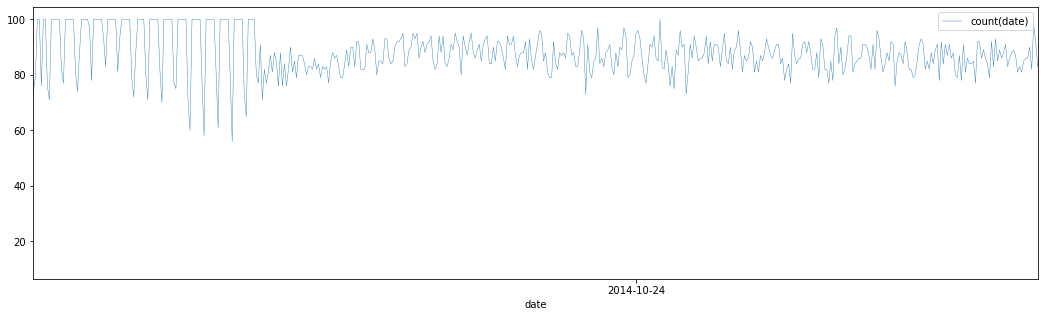

In [277]:
newsperday_pandas.plot(x="date" ,y="count(date)", figsize=(18,5),linestyle="-",linewidth=0.4,)
plt.xlim(700,1200)

In [310]:
news_trained = newsperday_pandas.copy(True)
news_trained['date'] = pd.to_datetime(news_trained['date'][:-20])
news_trained = news_trained.set_index('date')
news_trained.drop('UDate',1,inplace=True)

In [311]:
def test_stationarity(timeseries):
         
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print(dftest)
    print(dfoutput)

In [312]:
test_stationarity(news_trained)

Results of Dickey-Fuller Test:
Test Statistic                    0.496717
p-value                           0.984773
#Lags Used                       27.000000
Number of Observations Used    2281.000000
Critical Value (1%)              -3.433220
Critical Value (5%)              -2.862808
Critical Value (10%)             -2.567445
dtype: float64


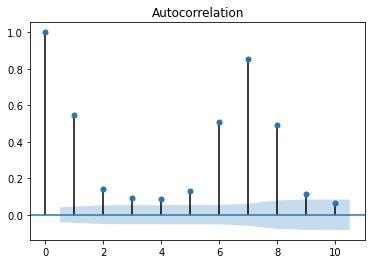

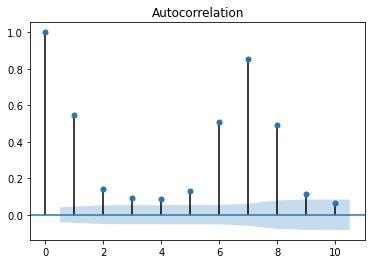

In [313]:
lag_acf = plot_acf(news_trained, lags=10)
display(lag_acf)


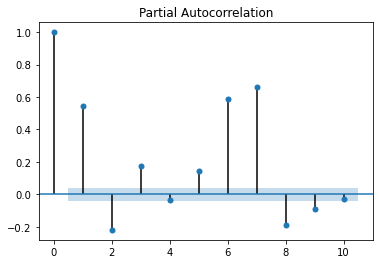

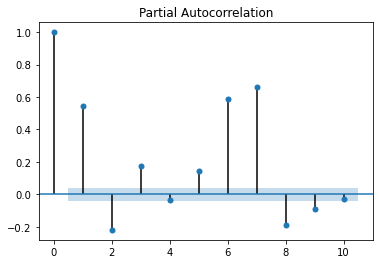

In [314]:
lag_pacf = plot_pacf(news_trained, lags=10)
display(lag_pacf)

In [343]:
import math

model = ARIMA(news_trained.astype(float), order=(2, 0, 1))   # uber_trained
results_ARIMA = model.fit(maxiter=500)  
print(results_ARIMA.summary())

/home/guna/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/guna/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


                              ARMA Model Results                              
Dep. Variable:            count(date)   No. Observations:                 2309
Model:                     ARMA(2, 1)   Log Likelihood               -9136.242
Method:                       css-mle   S.D. of innovations             12.651
Date:                Tue, 27 Oct 2020   AIC                          18282.484
Time:                        09:09:52   BIC                          18311.207
Sample:                             0   HQIC                         18292.954
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                86.9631      0.515    168.770      0.000      85.953      87.973
ar.L1.count(date)     0.1937      0.074      2.621      0.009       0.049       0.339
ar.L2.count(date)     0.

In [344]:
fitted_values  = results_ARIMA.predict(1,len(news_trained)-1,typ='linear')  # uber_trained
fitted_values_frame = fitted_values.to_frame()


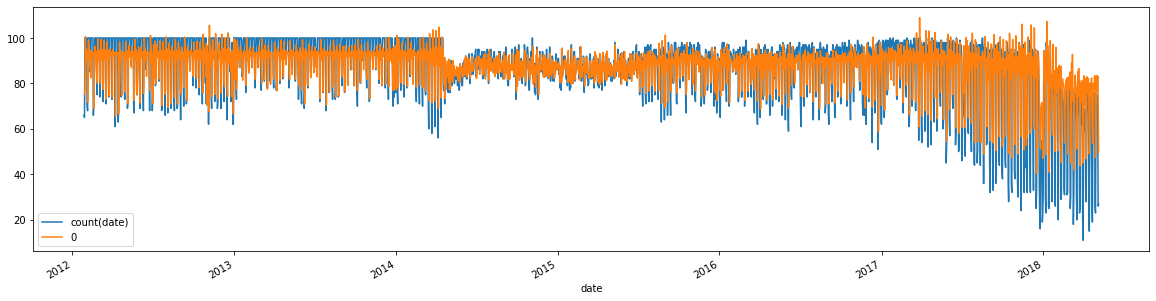

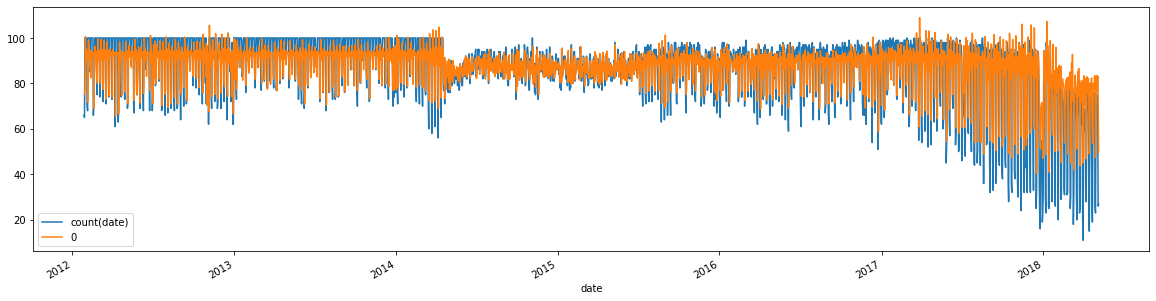

In [345]:
x = news_trained.merge(fitted_values_frame, how='outer', left_index=True, right_index=True)  #uber_trained
fig= x.plot(figsize=(20,5))
display(fig.figure)

                              ARMA Model Results                              
Dep. Variable:            count(date)   No. Observations:                 2309
Model:                     ARMA(2, 1)   Log Likelihood               -9136.242
Method:                       css-mle   S.D. of innovations             12.651
Date:                Tue, 27 Oct 2020   AIC                          18282.484
Time:                        09:10:02   BIC                          18311.207
Sample:                             0   HQIC                         18292.954
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                86.9631      0.515    168.770      0.000      85.953      87.973
ar.L1.count(date)     0.1937      0.074      2.621      0.009       0.049       0.339
ar.L2.count(date)     0.

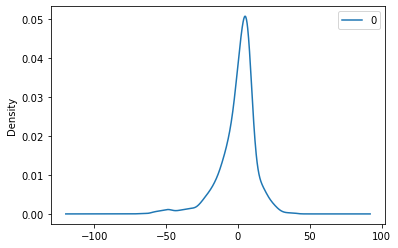

In [346]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [347]:
news_test =newsperday_pandas[-20:].copy(True)
news_test['date'] = pd.to_datetime(news_test['date'])
news_test = news_test.set_index('date')
news_test.drop('UDate',1,inplace=True)

In [352]:
model_test = ARIMA(news_test.astype(float),order=(2, 0,1))   # uber_trained

In [355]:
results_test_ARIMA = model_test.fit()

In [356]:
fitted_values_test  = results_test_ARIMA.predict(1,len(news_test)-1,typ='linear')  # uber_trained
fitted_values_test_frame = fitted_values_test.to_frame()

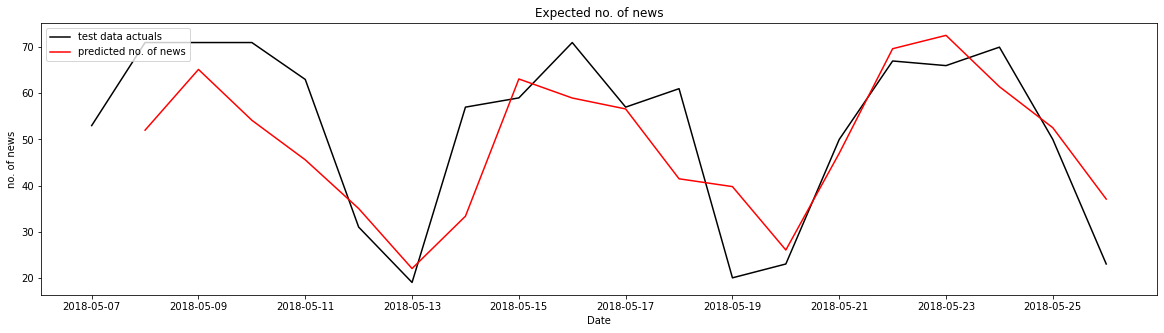

In [366]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set(title='Expected no. of news', xlabel='Date', ylabel='no. of news')
#aax.plot(news_trained, 'blue', label='training data')  # uber_trained
ax.plot(news_test, 'black', label='test data actuals')
ax.plot(fitted_values_test_frame, 'r', label='predicted no. of news')  # np.exp(predictions_series)
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [390]:
check = newsData.filter(newsData.link.contains('football'))

In [391]:
check.show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|      Mary Papenfuss|        CRIME|2018-02-18|Report: 2 Baylor ...|https://www.huffi...|The school has be...|
|          Ron Dicker|ENTERTAINMENT|2018-02-02|Alex Trebek Mocks...|https://www.huffi...|"If you guys ring...|
|          Ron Dicker|ENTERTAINMENT|2018-02-02|Justin Timberlake...|https://www.huffi...|The singer spoke ...|
|Harrison Wilkerso...| QUEER VOICES|2018-01-19|Gay Former Footba...|https://www.huffi...|Harrison Wilkerso...|
|                    |       SPORTS|2018-01-09|Alabama Rallies T...|https://www.huffi...|The Crimson Tide ...|
|          Ron Dicker|       COMEDY|2018-01-03|'The Opposition' ...|https://www.huffi...|"While the NFL is...|
|

In [392]:
check.toPandas().to_csv('mycsv.csv')

In [394]:
trump_data=newsData.filter(newsData.link.contains("trump"))

In [395]:
trump_data.show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|          Ron Dicker|ENTERTAINMENT|2018-05-26|Julianna Margulie...|https://www.huffi...|The "Dietland" ac...|
|          Ron Dicker|ENTERTAINMENT|2018-05-26|Donald Trump Is L...|https://www.huffi...|It's catchy, all ...|
|Michael Isikoff, ...|     POLITICS|2018-05-26|'Trump's Son Shou...|https://www.huffi...|The wiretaps feat...|
|      Mary Papenfuss|     POLITICS|2018-05-26|Edward Snowden: T...|https://www.huffi...|But don't count o...|
|      Mary Papenfuss|     POLITICS|2018-05-26|Booyah: Obama Pho...|https://www.huffi...|Just a peeping mi...|
|      Mary Papenfuss|     POLITICS|2018-05-26|Trump's Scottish ...|https://www.huffi...|And there are fou...|
|

In [396]:
trump_data.toPandas().to_csv('trump.csv')

In [397]:
title_category = newsData.select("category","headline")

In [402]:
def null_value_count(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows
            null_columns_counts.append(temp)
    return(null_columns_counts)

In [405]:
null_count=null_value_count(title_category)

In [407]:
print(null_count)

[]


In [408]:
title_category.count()

200853

In [409]:
title_category.show(truncate=False)

+-------------+---------------------------------------------------------------------------------------------+
|category     |headline                                                                                     |
+-------------+---------------------------------------------------------------------------------------------+
|CRIME        |There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV                             |
|ENTERTAINMENT|Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song                  |
|ENTERTAINMENT|Hugh Grant Marries For The First Time At Age 57                                              |
|ENTERTAINMENT|Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork                        |
|ENTERTAINMENT|Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog                      |
|ENTERTAINMENT|Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy             |
|ENTERTAIN

In [410]:
title_category.select("Category").distinct().count()

41

In [411]:
title_category.groupBy("Category").count().orderBy(col("count").desc()).show(truncate=False)

+--------------+-----+
|Category      |count|
+--------------+-----+
|POLITICS      |32739|
|WELLNESS      |17827|
|ENTERTAINMENT |16058|
|TRAVEL        |9887 |
|STYLE & BEAUTY|9649 |
|PARENTING     |8677 |
|HEALTHY LIVING|6694 |
|QUEER VOICES  |6314 |
|FOOD & DRINK  |6226 |
|BUSINESS      |5937 |
|COMEDY        |5175 |
|SPORTS        |4884 |
|BLACK VOICES  |4528 |
|HOME & LIVING |4195 |
|PARENTS       |3955 |
|THE WORLDPOST |3664 |
|WEDDINGS      |3651 |
|WOMEN         |3490 |
|IMPACT        |3459 |
|DIVORCE       |3426 |
+--------------+-----+
only showing top 20 rows



In [414]:
title_category.groupBy("headline").count().orderBy(col("count").desc()).show(truncate=False)


+-------------------------------------------------------------------------------+-----+
|headline                                                                       |count|
+-------------------------------------------------------------------------------+-----+
|Sunday Roundup                                                                 |90   |
|The 20 Funniest Tweets From Women This Week                                    |80   |
|Weekly Roundup of eBay Vintage Clothing Finds (PHOTOS)                         |59   |
|Weekly Roundup of eBay Vintage Home Finds (PHOTOS)                             |54   |
|Watch The Top 9 YouTube Videos Of The Week                                     |46   |
|The Funniest Tweets From Parents This Week                                     |41   |
|Animal Photos Of The Week                                                      |36   |
|Best Parenting Tweets: What Moms And Dads Said On Twitter This Week            |33   |
|The Funniest Tweets From Women 

In [416]:
title_category = title_category.withColumn("only_str",regexp_replace(col('headline'), '\d+', ''))

In [422]:
title_category.select("headline","only_str").show(truncate=False)

+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|headline                                                                                     |only_str                                                                                     |
+---------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV                             |There Were  Mass Shootings In Texas Last Week, But Only  On TV                               |
|Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song                  |Will Smith Joins Diplo And Nicky Jam For The  World Cup's Official Song                      |
|Hugh Grant Marries For The First Time At Age 57  

In [424]:
from pyspark.ml import Pipeline 
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [425]:
regex_tokenizer = RegexTokenizer(inputCol="only_str", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(title_category)

In [426]:
raw_words.show()

+-------------+--------------------+--------------------+--------------------+
|     category|            headline|            only_str|               words|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|There Were 2 Mass...|There Were  Mass ...|[there, were, mas...|
|ENTERTAINMENT|Will Smith Joins ...|Will Smith Joins ...|[will, smith, joi...|
|ENTERTAINMENT|Hugh Grant Marrie...|Hugh Grant Marrie...|[hugh, grant, mar...|
|ENTERTAINMENT|Jim Carrey Blasts...|Jim Carrey Blasts...|[jim, carrey, bla...|
|ENTERTAINMENT|Julianna Margulie...|Julianna Margulie...|[julianna, margul...|
|ENTERTAINMENT|Morgan Freeman 'D...|Morgan Freeman 'D...|[morgan, freeman,...|
|ENTERTAINMENT|Donald Trump Is L...|Donald Trump Is L...|[donald, trump, i...|
|ENTERTAINMENT|What To Watch On ...|What To Watch On ...|[what, to, watch,...|
|ENTERTAINMENT|Mike Myers Reveal...|Mike Myers Reveal...|[mike, myers, rev...|
|ENTERTAINMENT|What To Watch On ...|What To Watch On

In [427]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)

In [428]:
words_df.show()

+-------------+--------------------+--------------------+--------------------+--------------------+
|     category|            headline|            only_str|               words|            filtered|
+-------------+--------------------+--------------------+--------------------+--------------------+
|        CRIME|There Were 2 Mass...|There Were  Mass ...|[there, were, mas...|[mass, shootings,...|
|ENTERTAINMENT|Will Smith Joins ...|Will Smith Joins ...|[will, smith, joi...|[smith, joins, di...|
|ENTERTAINMENT|Hugh Grant Marrie...|Hugh Grant Marrie...|[hugh, grant, mar...|[hugh, grant, mar...|
|ENTERTAINMENT|Jim Carrey Blasts...|Jim Carrey Blasts...|[jim, carrey, bla...|[jim, carrey, bla...|
|ENTERTAINMENT|Julianna Margulie...|Julianna Margulie...|[julianna, margul...|[julianna, margul...|
|ENTERTAINMENT|Morgan Freeman 'D...|Morgan Freeman 'D...|[morgan, freeman,...|[morgan, freeman,...|
|ENTERTAINMENT|Donald Trump Is L...|Donald Trump Is L...|[donald, trump, i...|[donald, trump, l...|


In [429]:
words_df.select("words","filtered").show()

+--------------------+--------------------+
|               words|            filtered|
+--------------------+--------------------+
|[there, were, mas...|[mass, shootings,...|
|[will, smith, joi...|[smith, joins, di...|
|[hugh, grant, mar...|[hugh, grant, mar...|
|[jim, carrey, bla...|[jim, carrey, bla...|
|[julianna, margul...|[julianna, margul...|
|[morgan, freeman,...|[morgan, freeman,...|
|[donald, trump, i...|[donald, trump, l...|
|[what, to, watch,...|[watch, amazon, p...|
|[mike, myers, rev...|[mike, myers, rev...|
|[what, to, watch,...|[watch, hulu, new...|
|[justin, timberla...|[justin, timberla...|
|[south, korean, p...|[south, korean, p...|
|[with, its, way, ...|[way, life, risk,...|
|[trump, s, crackd...|[trump, crackdown...|
|[trump, s, son, s...|[trump, son, conc...|
|[edward, snowden,...|[edward, snowden,...|
|[booyah, obama, p...|[booyah, obama, p...|
|[ireland, votes, ...|[ireland, votes, ...|
|[ryan, zinke, loo...|[ryan, zinke, loo...|
|[trump, s, scotti...|[trump, sc

In [430]:
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
feature_data = indexer.fit(words_df).transform(words_df)

In [431]:
feature_data.select("category","categoryIndex").show()

+-------------+-------------+
|     category|categoryIndex|
+-------------+-------------+
|        CRIME|         20.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|ENTERTAINMENT|          2.0|
|   WORLD NEWS|         28.0|
|       IMPACT|         18.0|
|     POLITICS|          0.0|
|     POLITICS|          0.0|
|     POLITICS|          0.0|
|     POLITICS|          0.0|
|     POLITICS|          0.0|
|     POLITICS|          0.0|
|     POLITICS|          0.0|
+-------------+-------------+
only showing top 20 rows



In [432]:
cv = CountVectorizer(inputCol="filtered", outputCol="features")
model = cv.fit(feature_data)
countVectorizer_feateures = model.transform(feature_data)

In [433]:
(trainingData, testData) = countVectorizer_feateures.randomSplit([0.8, 0.2],seed = 11)

In [434]:
nb = NaiveBayes(modelType="multinomial",labelCol="categoryIndex", featuresCol="features")
nbModel = nb.fit(trainingData)
nb_predictions = nbModel.transform(testData)



In [435]:
nb_predictions.select("prediction", "categoryIndex", "features").show(5)

+----------+-------------+--------------------+
|prediction|categoryIndex|            features|
+----------+-------------+--------------------+
|       2.0|         35.0|(54463,[113,1036,...|
|       2.0|         35.0|(54463,[8,45,276,...|
|       7.0|         35.0|(54463,[8,46,381,...|
|       3.0|         35.0|(54463,[2,84,125,...|
|       5.0|         35.0|(54463,[11,50,128...|
+----------+-------------+--------------------+
only showing top 5 rows



In [436]:
evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g"% (nb_accuracy))
print("Test Error of NaiveBayes = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is = 0.527288
Test Error of NaiveBayes = 0.472712 
